# SKOS relation classifier using Convolutional Neural Networks 


## 1. Loading  data

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('DET_relations_with_vectors_and_similarity.csv', sep='|', error_bad_lines=True, header=None, skiprows=[0])
#(1-related, 2-broader, 3-narrower)
sample_size = data.shape[0]
print(data.shape[1])
print(data.shape[0])

1807
6334


In [40]:
data2 = pd.read_csv('DET_SKOS_with_text/DET_SKOS_with_text.csv', sep='|', error_bad_lines=True, header=None, skiprows=[0])
print(data2.shape[1])
print(data2.shape[0])

1808
21453


In [41]:
data2 = pd.read_csv('EuroVoc_relations.csv', sep='|', error_bad_lines=True, header=None, skiprows=[0])
print(data2.shape[1])
print(data2.shape[0])

1807
25529


In [3]:
print(data[0:3])

        0         1                   2         3         4        5     \
0  financing  narrower  national financing -0.056675  0.035477  0.38898   
1  financing  narrower           insurance -0.056675  0.035477  0.38898   
2  financing  narrower        co-financing -0.056675  0.035477  0.38898   

      6       7        8       9     ...      1797      1798      1799  \
0  0.20214 -0.8511  0.44458 -2.5219  ... -0.011671 -0.047043 -0.049948   
1  0.20214 -0.8511  0.44458 -2.5219  ... -0.181320 -0.288950 -0.424160   
2  0.20214 -0.8511  0.44458 -2.5219  ... -0.000419 -0.008418  0.127442   

       1800      1801      1802      1803      1804      1805  1806  
0  0.140644 -0.197608 -0.167535  0.040048 -0.103548 -0.075693     3  
1  0.246160 -0.181430 -0.848650 -0.482410  0.555980 -0.192040     3  
2  0.016293  0.087195 -0.000012  0.009600  0.010503 -0.017263     3  

[3 rows x 1807 columns]


In [31]:
print(data[1807][10]) #sentence with skos pair example 

this included satellite manufacture, launch services, ground station construction, project financing, insurance and training.


In [ ]:
pd.concat([data,data1], axis=1)

## 2. Creation doc2vec model for sentences

version 1: Learn doc2vec using w2v model glove.6B.300d.bin 

In [56]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data[1807]) ]
model = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)

In [58]:
from gensim.test.utils import get_tmpfile
model.save('d2v')

In [59]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
model = Doc2Vec.load('d2v')  

In [60]:
vector = model.infer_vector([data[1807][10]])

In [61]:
print(vector)

[-5.32460690e-04 -1.02543749e-03 -3.54235322e-04  3.34173092e-04
  4.64170414e-04  8.89081624e-04  1.33694755e-03  1.71160718e-04
  9.70604247e-04  1.40406634e-03 -1.45082094e-03 -3.86855012e-04
  5.49832359e-04 -8.40430730e-04  1.59280899e-03  5.17901091e-04
 -3.07378883e-04  3.15133278e-04  8.24002025e-04  1.16335868e-03
 -9.06945555e-04  3.50807059e-05 -3.69356479e-04  1.00273255e-03
  4.62539698e-04 -1.39928330e-03  2.55582883e-04  1.44802313e-03
 -7.85864249e-04 -1.86246194e-04  4.82530550e-06 -4.61453485e-04
 -7.57822534e-04  1.52424397e-03  7.49113096e-04 -1.05305691e-04
  4.81404539e-04 -1.62749144e-04 -5.10471058e-04  9.59155499e-04
 -2.16216256e-04 -1.38301199e-04 -2.70434757e-05  1.58524397e-03
  1.28486997e-03 -8.14087049e-04 -1.13212760e-03  2.12709929e-04
  5.79662097e-04  8.42102105e-04  1.04277383e-03  5.68517891e-04
 -9.84888524e-04 -1.16782752e-03 -4.91584709e-04  3.21671861e-04
  1.26734725e-03 -2.91924604e-04  3.31065734e-04 -1.81067808e-04
 -1.33650342e-03  1.60337

In [62]:
# generate doc. vectors for all sentences
from IPython.display import clear_output
import datetime
w1=[]
for i in range(0,len(data)):
    clear_output(wait=True)
    print((i+1)/(len(data)+1))
    #print(i)
    vector = model.infer_vector([data[1807][i]])
    w1.append(vector)
    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:
print(len(w1))
print(len(data))

21453
21453


version 2: Get the syntactic roles of words in a sentence

In [123]:
import pandas as pd
import numpy as np
import codecs
import string
import re
import pymorphy2
import gensim
import spacy
import os
import random
import numpy as np
from datetime import datetime
from tqdm import tqdm


SEP = '|'
BROADER_STRIPPED_FILE = True
UNIQUE_BROADER_CONCEPTS = True
POS_EXCEPTIONS = ['PUNCT',] #  'ADP'
SPACY_MODEL = 'en_core_web_lg'
MODELS_USING_POS_TAG = ['200l.bin', ]
NOISE_FILE_AMOUNT = 2
model_path='glove.6B.300d.bin'

nlp = spacy.load(SPACY_MODEL)
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)
concept_buffer = {}

In [160]:
w1=data[0][2]
w2=data[2][2]
print(w1," - ",w2)
t="the joint programme aims to assist timor leste's government to develop and establish a holistic and integrated national financing framework which will help to improve the governance and coordination, articulate a financing strategy and strengthen the monitoring and oversight framework"
dep1=0
dep2=0
pos1=0
pos2=0
dep11=0
dep22=0
pos11=0
pos22=0

doc = nlp(t)
doc = [token for token in doc if token.pos_ not in POS_EXCEPTIONS]

param = []
for token in doc:
    if len(w1.split())==2:
        lst = w1.replace('.', '').split()
        if lst[0]==token.text:
                print([f"L0_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                dep1=token.dep
                pos1=token.pos
        if lst[1]==token.text:
                print([f"L1_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                dep11=token.dep
                pos11=token.pos
    else:
            if w1==token.text:
                print([f"1_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                dep1=token.dep
                pos1=token.pos
           
    if len(w2.split())==2:
        lst2 = w2.split()
        
        if lst2[0]==token.text:
                print([f"L20_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                dep2=token.dep
                pos2=token.pos
        if lst2[1]==token.text:
                print([f"L21_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                dep22=token.dep
                pos22=token.pos
    else:
            if w2==token.text:
                print([f"2_{token.text}_2_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                dep2=token.dep
                pos2=token.pos
param.append([dep1,dep2,dep11,dep22,pos1,pos2,pos11,pos22])
print(len(w1.split())) 

financing  -  national financing
['L20_national_1_Degree=Pos_402_84_0']
['1_financing_1_Number=Sing_7037928807040764755_92_0']
['L21_financing_1_Number=Sing_7037928807040764755_92_0']
['1_financing_1_Number=Sing_7037928807040764755_92_0']
['L21_financing_1_Number=Sing_7037928807040764755_92_0']
1


In [161]:
print(param)

[[7037928807040764755, 402, 0, 7037928807040764755, 92, 84, 0, 92]]


In [141]:
data[1807][2]

"the joint programme aims to assist timor leste's government to develop and establish a holistic and integrated national financing framework which will help to improve the governance and coordination, articulate a financing strategy and strengthen the monitoring and oversight framework."

In [165]:
# geting syntactic roles of words in the sentence for all pairs 
from IPython.display import clear_output
import datetime

param = []

for i in range(0,len(data)):
    clear_output(wait=True)
    print((i+1)/(len(data)+1))
    #print(i)
    
    w1=data[0][i]
    w2=data[2][i]
    sent=data[1807][i]
    dep1=0
    dep2=0
    pos1=0
    pos2=0
    dep11=0
    dep22=0
    pos11=0
    pos22=0

    if (len(sent)<1000):
        doc = nlp(sent)
    doc = [token for token in doc if token.pos_ not in POS_EXCEPTIONS]
    for token in doc:
        if len(w1.split())==2:
            lst = w1.replace('.', '').split()
            if lst[0]==token.text:
                    print([f"L0_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                    dep1=token.dep
                    pos1=token.pos
            if lst[1]==token.text:
                    print([f"L1_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                    dep11=token.dep
                    pos11=token.pos
        else:
                if w1==token.text:
                    print([f"1_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                    dep1=token.dep
                    pos1=token.pos

        if len(w2.split())==2:
            lst2 = w2.split()

            if lst2[0]==token.text:
                    print([f"L20_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                    dep2=token.dep
                    pos2=token.pos
            if lst2[1]==token.text:
                    print([f"L21_{token.text}_1_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                    dep22=token.dep
                    pos22=token.pos
        else:
                if w2==token.text:
                    print([f"2_{token.text}_2_{token.morph}_{token.dep}_{token.pos}_{token.cluster}"])
                    dep2=token.dep
                    pos2=token.pos
    param.append([dep1,dep2,dep11,dep22,pos1,pos2,pos11,pos22])


    

0.999953388645474
['L0_vaccination_1_Number=Sing_7037928807040764755_92_0']
['L0_vaccination_1_Number=Sing_439_92_0']
['L0_vaccination_1_Number=Sing_439_92_0']
['2_travel_2_Number=Sing_439_92_0']


In [166]:
pd.DataFrame(param).to_csv("nlp.csv",header=None, index=None)

In [32]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

text = 'this included satellite manufacture, launch services, ground station construction, project financing, insurance and training.'
doc = Doc(text)


In [34]:
doc.segment(segmenter)
display(doc.tokens[:5])
display(doc.sents[:5])

[DocToken(stop=4, text='this'),
 DocToken(start=5, stop=13, text='included'),
 DocToken(start=14, stop=23, text='satellite'),
 DocToken(start=24, stop=35, text='manufacture'),
 DocToken(start=35, stop=36, text=',')]

[DocSent(stop=125, text='this included satellite manufacture, launch servi..., tokens=[...])]

In [35]:
doc.tag_morph(morph_tagger)
display(doc.tokens[:5])
doc.sents[0].morph.print()

[DocToken(stop=4, text='this', pos='X', feats=<Yes>),
 DocToken(start=5, stop=13, text='included', pos='X', feats=<Yes>),
 DocToken(start=14, stop=23, text='satellite', pos='X', feats=<Yes>),
 DocToken(start=24, stop=35, text='manufacture', pos='X', feats=<Yes>),
 DocToken(start=35, stop=36, text=',', pos='PUNCT')]

                this X|Foreign=Yes
            included X|Foreign=Yes
           satellite X|Foreign=Yes
         manufacture X|Foreign=Yes
                   , PUNCT
              launch X|Foreign=Yes
            services X|Foreign=Yes
                   , PUNCT
              ground X|Foreign=Yes
             station X|Foreign=Yes
        construction X|Foreign=Yes
                   , PUNCT
             project X|Foreign=Yes
           financing X|Foreign=Yes
                   , PUNCT
           insurance X|Foreign=Yes
                 and X|Foreign=Yes
            training X|Foreign=Yes
                   . PUNCT


In [25]:
#print(data['subConceptVector'][0])
#print(data['mainConceptVector'][0])
# для вывода прогресса, обработка занимет много времени :(
from IPython.display import clear_output
    clear_output(wait=True)
    print((i+1)/309533)
# для генерации имени файла, надоело делать это вручную
import datetime

w1=[]
w2=[]
for i in range(0,309532):
    #print(i)
    clear_output(wait=True)
    print((i+1)/309533)
    
    vx=data['mainConceptVector'][i]
    vy=data['subConceptVector'][i]
    
    vx=vx.replace('[', "")
    vx=vx.replace(']', "")
    vx=vx.replace('\n', " ")
    vx=vx.replace('   ', " ")
    vx=vx.replace('  ', " ")
    vx=vx.replace(',', "")
    if vx[0]==' ':
        vx = vx[1:]
    w11=vx.split(' ')
   #w1.append(w11)
    
    vy=vy.replace('[', "")
    vy=vy.replace(']', "")
    vy=vy.replace('\n', " ")
    vy=vy.replace('   ', " ")
    vy=vy.replace('  ', " ")
    vy=vy.replace(',', "")
    if vy[0]==' ':
        vy = vy[1:]
    w22=vy.split(' ')
    w1.append(w11+w22)
    

0.9999967693266953


In [66]:
pd.DataFrame(w1).to_csv("d2v.csv",header=None, index=None)

In [67]:
vector2 = pd.read_csv('d2v.csv', sep=',', error_bad_lines=True,header=None) #, header=0

In [81]:
#dataset merge
data2 = pd.read_csv('DET_SKOS_with_text/DET_SKOS_with_text.csv', sep='|', error_bad_lines=True, skiprows=[0],header=None) #, header=0
vector2 = pd.read_csv('vectors2.csv', sep=',', error_bad_lines=True,header=None) #, header=0

In [82]:
merged =pd.concat([data2,vector2], axis =1 ,ignore_index=True)

In [168]:
param = pd.read_csv('nlp.csv', sep=',', error_bad_lines=True,header=None) #, header=0

In [170]:
merged2 =pd.concat([merged,param], axis =1 ,ignore_index=True)

In [83]:
pd.DataFrame(merged).to_csv("compile-01.csv",header=None, index=None) #vec + docvec + sintax

In [100]:
print(merged.shape[0])
print(merged.shape[1])

21453
2108


In [173]:
print(merged2.shape[0])
print(merged2.shape[1])

21453
2116


## 3. Train process

In [174]:

import numpy as np
import ctypes
import pandas as pd
import tensorflow as tf  #1.14

seed = 105
np.random.seed(seed)
data2 = merged2

In [4]:
print(data[1806])

0       3
1       3
2       3
3       3
4       3
       ..
6329    2
6330    1
6331    1
6332    1
6333    1
Name: 1806, Length: 6334, dtype: int64


In [5]:
print(data)

                         0         1                   2         3     \
0                   financing  narrower  national financing -0.056675   
1                   financing  narrower           insurance -0.056675   
2                   financing  narrower        co-financing -0.056675   
3                   financing  narrower        microfinance -0.056675   
4                   financing  narrower        crowdfunding -0.056675   
...                       ...       ...                 ...       ...   
6329  vaccination certificate   broader         vaccination  0.308965   
6330  vaccination certificate   related             vaccine  0.308965   
6331  vaccination certificate   related  emergency response  0.308965   
6332  vaccination certificate   related      tourism policy  0.308965   
6333  vaccination certificate   related              travel  0.308965   

          4         5         6         7         8       9     ...      1797  \
0     0.035477  0.388980  0.202140 -0.8511

In [103]:
print(data2[2107])

0       -0.001285
1        0.000503
2       -0.001550
3       -0.000831
4       -0.000975
           ...   
21448    0.000942
21449   -0.000408
21450   -0.000978
21451   -0.000562
21452   -0.001034
Name: 2107, Length: 21453, dtype: float64


In [184]:
data2 = data2.drop(data2.columns[[1807, 1806]], axis=1)

In [186]:
print(data2[1809][0])

-0.001648909179493785


In [187]:
print(data2[2115][0])

92


In [255]:
data = pd.read_csv('db10-1.csv', sep='|', error_bad_lines=True, header=None)


In [11]:
print (data.shape[0])
print (data.shape[1])
print (data[1806])

6334
1807
0       3
1       3
2       3
3       3
4       3
       ..
6329    2
6330    1
6331    1
6332    1
6333    1
Name: 1806, Length: 6334, dtype: int64


In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf  #1.14

seed = 105
np.random.seed(seed)
#data = pd.read_csv('compile-1.csv', sep="|", header=None,low_memory=False)

#X1 = data.iloc[:,3:1805].astype(float) #means of vectors and sum of vectors
#X1 = data.iloc[:,3:604].astype(float) #only means vectors
X2 = data2.iloc[:,3:1805].astype(float) #all vectors + sentence vectors and one broader class
#X1 = data.iloc[:,3:602].astype(float)
#X2 = data.iloc[:,1808:2107].astype(float)
#X =pd.concat([X1,X2], axis =1 ,ignore_index=True)
X=X2
Y = data2.iloc[:,1806].astype(int)
print(Y[10])

3


In [14]:
print(X[301])

0       0.179550
1       0.179550
2       0.179550
3       0.179550
4       0.179550
          ...   
6329   -0.477945
6330   -0.477945
6331   -0.477945
6332   -0.477945
6333   -0.477945
Name: 301, Length: 6334, dtype: float64


In [258]:
Y = data.iloc[:,603]

In [50]:
Ytxt = data2.iloc[:,1806].astype(int) #data.iloc[:,603]
#16725 0  related
#6523  1  broader
#40101 2  empty

In [51]:
Y=Ytxt
c0=0
c1=0
c2=0
c3=0
c4=0
for i in range(0,len(Ytxt)):
    #Y[i]=0
    if Ytxt[i]==0:  
        Y[i]=0
        c0=c0+1
    if Ytxt[i]==1:
        Y[i]=0
        c1=c1+1
        
    if Ytxt[i]==2:
        Y[i]=1
        c2=c2+1
    if Ytxt[i]==-1:
        Y[i]=0
        c4=c4+1
    if Ytxt[i]==3:
        Y[i]=0
        c3=c3+1


In [52]:
print (len(Ytxt))
print (c0)
print (c1)
print (c2)
print (c3)
print (c4)

25529
0
10848
7340
7341
0


In [41]:
Y1=[]
for i in range(0,len(Y)):
    if Y[i]!=2:
        Y[i]=0
    

In [265]:
Y1=[]
for i in range(0,len(Y)):
    if Y[i]==2:
        Y[i]=0

c:\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
print(Y)

0       0
1       0
2       0
3       0
4       0
       ..
6329    0
6330    0
6331    0
6332    0
6333    0
Name: 1806, Length: 6334, dtype: int32


In [261]:
print(Y[100])

0


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


In [18]:
from keras import Sequential
from keras.layers import Dense

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=50)
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(1802,), name='digits')

x = layers.Dense(1200, activation='softmax', name='dense_1')(inputs)
y = layers.Dense(600, activation='sigmoid', name='dense_2')(x)#sigmoid
z = layers.Dense(300, activation='softmax', name='dense_3')(y)
z1 = layers.Dense(50, activation='softmax', name='dense_4')(z)
outputs = layers.Dense(2, activation='softmax', name='predictions')(z1)

model = keras.Model(inputs=inputs, outputs=outputs)

#v tf.keras.losses
#pip install --force-reinstall tensorflow

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
 #            loss='binary_crossentropy',              #'precision',
            metrics=['sparse_categorical_crossentropy','accuracy']
            )

tf.keras.callbacks.ModelCheckpoint(
    "cnn.hdf5", monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
    
)

with tf.device('/gpu:0'):                          #5
    history=model.fit(X_train, Y_train, batch_size=10, epochs=7, verbose=1,shuffle=1, validation_data=(X_test, Y_test),validation_split=1)
print('\nhistory dict:', history.history)

print('\n# Оцениваем на тестовых данных')
results = model.evaluate(X_test, Y_test, batch_size=7)
print('test loss, test acc:', results)










Train on 19146 samples, validate on 6383 samples
Epoch 1/7
19146/19146 [==============================] - 46s 2ms/sample - loss: 0.6069 - sparse_categorical_crossentropy: 0.6069 - acc: 0.7098 - val_loss: 0.5934 - val_sparse_categorical_crossentropy: 0.5934 - val_acc: 0.7196
Epoch 2/7
19146/19146 [==============================] - 45s 2ms/sample - loss: 0.6023 - sparse_categorical_crossentropy: 0.6023 - acc: 0.7101 - val_loss: 0.5934 - val_sparse_categorical_crossentropy: 0.5934 - val_acc: 0.7196
Epoch 3/7
19146/19146 [==============================] - 45s 2ms/sample - loss: 0.6023 - sparse_categorical_crossentropy: 0.6023 - acc: 0.7101 - val_loss: 0.5934 - val_sparse_categorical_crossentropy: 0.5934 - val_acc: 0.7196
Epoch 4/7
19146/19146 [==============================] - 45s 2ms/sample - loss: 0.6023 - sparse_categorical_crossentropy: 0.6023 - acc: 0.7101 - val_loss: 0.5937 - val_sparse_categorical_crossentropy: 0.5937 - val_acc: 0.7196
Epoch 5/7
19146/19146 [========================

In [89]:
print(X[2:3])

        3         4        5        6       7        8       9        10   \
2 -0.056675  0.035477  0.38898  0.20214 -0.8511  0.44458 -2.5219  0.31609   

       11       12   ...       593       594       595      596       597  \
2 -0.15525  0.71965  ... -0.117382 -0.109009  0.096719 -0.13341 -0.119905   

        598       599       600      601      602  
2 -0.375135 -0.351895  0.202775 -0.20055 -0.19858  

[1 rows x 600 columns]


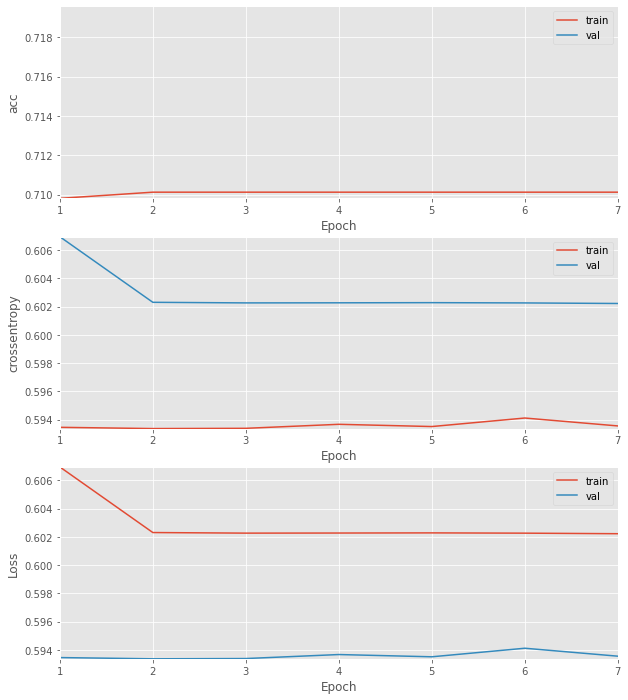

In [56]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10, 12))
    ax1, ax2, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['acc'], history.history['val_acc'], 'acc')
    plot_metrix(ax2, history.history['val_sparse_categorical_crossentropy'], history.history['sparse_categorical_crossentropy'], 'crossentropy')
    #plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    

    
    
    plt.show()


plot_history(history)



In [269]:
model.save_weights('glove.6B.300d-3.hdf5')

## 4. Adding syntactic features to the training vectors

In [5]:
#print(data['mainConcept'][59])
posm=[]
Animacym=[]
Casem=[]
Genderm=[]
Numberm=[]
Dposm=[]
DAnimacym=[]
DCasem=[]
DGenderm=[]
DNumberm=[]
w1=[]
w2=[]
for i in range(309533):
    #print(i)
    x=data['mainConcept'][i]
    y=data['subConcept'][i]
    vx=data['mainConceptVector'][i]
    vy=data['subConceptVector'][i]
    
    pos2=x.split("'pos': ")
    pos3=pos2[1].split(',')
    pos=pos3[0]
    an2=x.split("'Animacy': ")
    if len(an2)>>1 :
        an3=an2[1].split(',')
        Animacy=an3[0]
    else:
        Animacy=0
    Case2=x.split("'Case': ")
    if len(Case2)>>1 :
        Case3=Case2[1].split(',')
        Case=Case3[0]
    else:
        Case=0
    Gender2=x.split("'Gender': ")
    if len(Gender2)>>1 :
        Gender3=Gender2[1].split(',')
        Gender=Gender3[0]
    else:
        Gender=0
    Number2=x.split("'Number': ")
    if len(Number2)>>1 :
        Number3=Number2[1].split('}')
        Number=Number3[0]
    else:
        Number=0
    posm.append(pos)
    Animacym.append(Animacy)
    Casem.append(Case)
    Genderm.append(Gender)
    Numberm.append(Number)
    
    pos2=y.split("'pos': ")
    pos3=pos2[1].split(',')
    pos=pos3[0]
    an2=x.split("'Animacy': ")
    if len(an2)>>1 :
        an3=an2[1].split(',')
        Animacy=an3[0]
    else:
        Animacy=0
    Case2=y.split("'Case': ")
    if len(Case2)>>1 :
        Case3=Case2[1].split(',')
        Case=Case3[0]
    else:
        Case=0
    Gender2=y.split("'Gender': ")
    if len(Gender2)>>1 :
        Gender3=Gender2[1].split(',')
        Gender=Gender3[0]
    else:
        Gender=0
    Number2=y.split("'Number': ")
    if len(Number2)>>1 :
        Number3=Number2[1].split('}')
        Number=Number3[0]
    else:
        Number=0
    Dposm.append(pos)
    DAnimacym.append(Animacy)
    DCasem.append(Case)
    DGenderm.append(Gender)
    DNumberm.append(Number)

    vx=vx.replace('\n', "")
    vx=vx.replace('  ', " ")
    w11=vx.split(' ')
    w1.append(w11)
    
    vy=vy.replace('\n', "")
    vy=vy.replace('  ', " ")
    w22=vy.split(' ')
    w2.append(w22)
    
data2 = np.hstack((data, np.atleast_2d(posm).T)) 
data = np.hstack((data2, np.atleast_2d(Animacym).T))
data2 = np.hstack((data, np.atleast_2d(Casem).T))
data = np.hstack((data2, np.atleast_2d(Genderm).T))
data2 = np.hstack((data, np.atleast_2d(Numberm).T))
#data=data2
data = np.hstack((data2, np.atleast_2d(Dposm).T)) 
data2 = np.hstack((data, np.atleast_2d(DAnimacym).T))
data = np.hstack((data2, np.atleast_2d(DCasem).T))
data2 = np.hstack((data, np.atleast_2d(DGenderm).T))
data = np.hstack((data2, np.atleast_2d(DNumberm).T))

#data=np.hstack((data2, np.atleast_2d(w1)))
#data2=np.hstack((data, np.atleast_2d(w2)))
print(data.shape[1])
print(data.shape[0])


#print(posm[:5])

16
309533


In [6]:

pd.DataFrame(data).to_csv("data-16.csv",header=None, index=None)

In [103]:

pd.DataFrame(w1).to_csv("w1.csv",header=None, index=None)
pd.DataFrame(w2).to_csv("w2.csv",header=None, index=None)

In [28]:
import pandas as pd
import numpy as np

#print(data[0])
#print(w1)
data = pd.read_csv('data12.csv', sep=',', error_bad_lines=True,header=None) #, header=0
vector = pd.read_csv('vectors2.csv', sep=',', error_bad_lines=True,header=None) #, header=0

In [36]:
print(data.shape[1])
print(data.shape[0])
print(vector.shape[1])
print(vector[599])
#merged = data.merge(vector)
data = pd.read_csv('data12.csv', sep=',', error_bad_lines=True,header=None) #, header=0
merged =pd.concat([data,vector], axis =1 ,ignore_index=True)
#merged.to_csv("output.csv", index=False)

12
309532
605
0        -0.018872
1         0.514745
2        -0.508416
3         0.297453
4         0.514745
            ...   
309527   -0.305127
309528    0.148135
309529    0.861113
309530    0.401059
309531    0.298052
Name: 599, Length: 309532, dtype: float64


In [37]:
print(merged.shape[1])
print(merged.shape[0])
print(merged[14])

617
309532
0        -0.240118
1         0.801209
2         0.801209
3         0.801209
4         0.801209
            ...   
309527    0.354652
309528   -0.300626
309529   -0.388826
309530   -0.388826
309531   -0.508017
Name: 14, Length: 309532, dtype: float64


In [ ]:
#print(data.shape[1])
#print(data.shape[0])
#print(len(w1))
#print(data[11])
#print(w1[309531])
data2=[]
for i in range(0,10):
    #clear_output(wait=True)
   # print((i+1)/309533)
    data3=[]
    print(data[0][i])
    #print(str(data[0][i])+data[1][i]+data[2][i]+data[3][i]+data[4][i]+data[5][i]+data[5][i]+data[6][i]+data[7][i]+data[8][i]+data[9][i]+data[10][i]+data[11][i]+w1[i])

In [ ]:
data2 = np.hstack((data, np.atleast_2d(w1)))

In [111]:
w1 = pd.read_csv('w1.csv', sep=',', error_bad_lines=True,header=None) #, header=0
#w2 = pd.read_csv('w2.csv', sep=',', error_bad_lines=True,header=None) #, header=0


c:\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (300,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,362) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
from IPython.display import clear_output
import datetime

data2=[]
from numba import njit
@njit
def f(m,n,data):
    
    for i in range(m,n):
        data2=[]
        newrow=[]
        newrow.append(data[2][i])
        newrow.append(data[3][i])
        newrow.append(data[6][i])
        newrow.append(data[7][i])
        newrow.append(data[8][i])
        newrow.append(data[9][i])
        newrow.append(data[10][i])
        newrow.append(data[11][i])
        newrow.append(data[12][i])
        newrow.append(data[13][i])
        newrow.append(data[14][i])
        newrow.append(data[15][i])
        data2.append(newrow)
    return data2
#data2= f(1,30000,data)
from multiprocess import Pool #! pip install multiprocess
for i in range(1,309533):
    clear_output(wait=True)
    print((i+1)/309533)
    newrow=[]
    newrow.append(data[2][i])
    newrow.append(data[3][i])
    newrow.append(data[6][i])
    newrow.append(data[7][i])
    newrow.append(data[8][i])
    newrow.append(data[9][i])
    newrow.append(data[10][i])
    newrow.append(data[11][i])
    newrow.append(data[12][i])
    newrow.append(data[13][i])
    newrow.append(data[14][i])
    newrow.append(data[15][i])
    #data2 = np.concatenate((data2,newrow))
    #data2 = np.insert(data2, i-1, newrow, axis=0)
    data2.append(newrow)

0.9986689625984951


In [110]:
pd.DataFrame(data2).to_csv("data12.csv",header=None, index=None)

In [ ]:
Dposm=[]
DAnimacym=[]
DCasem=[]
DGenderm=[]
DNumberm=[]
w1=[]
w2=[]
for i in range(309533):
    pos2=y.split("'pos': ")
    pos3=pos2[1].split(',')
    pos=pos3[0]
    an2=x.split("'Animacy': ")
    if len(an2)>>1 :
        an3=an2[1].split(',')
        Animacy=an3[0]
    else:
        Animacy=0
    Case2=y.split("'Case': ")
    if len(Case2)>>1 :
        Case3=Case2[1].split(',')
        Case=Case3[0]
    else:
        Case=0
    Gender2=y.split("'Gender': ")
    if len(Gender2)>>1 :
        Gender3=Gender2[1].split(',')
        Gender=Gender3[0]
    else:
        Gender=0
    Number2=y.split("'Number': ")
    if len(Number2)>>1 :
        Number3=Number2[1].split('}')
        Number=Number3[0]
    else:
        Number=0
    Dposm.append(pos)
    DAnimacym.append(Animacy)
    DCasem.append(Case)
    DGenderm.append(Gender)
    DNumberm.append(Number)

    vx=vx.replace('\n', "")
    vx=vx.replace('  ', " ")
    w11=vx.split(' ')
    w1.append(w11)
    
    vy=vy.replace('\n', "")
    vy=vy.replace('  ', " ")
    w22=vy.split(' ')
    w2.append(w22)

data2 = np.hstack((data, np.atleast_2d(Dposm).T)) 
data = np.hstack((data2, np.atleast_2d(DAnimacym).T))
data2 = np.hstack((data, np.atleast_2d(DCasem).T))
data = np.hstack((data2, np.atleast_2d(DGenderm).T))
data2 = np.hstack((data, np.atleast_2d(DNumberm).T))

In [97]:
s=data2[0][1]
s=s.replace('\n', "")
s=s.replace('  ', " ")
w1=s.split(' ')
#data2[0][1]=s
print(len(w1))
print(w1[301])

301
1.44618064e-01]


In [51]:
from collections import Counter
#текстовые поля 
#h=['depw_upostag','depw_gender','depw_animacy','depw_number','depw_case','depw_degree',
#  'depw_verbform','depw_mood','depw_tense','depw_aspect','depw_voice','UD_dependence','mainw_upostag','mainw_gender','mainw_animacy','mainw_number','mainw_case','mainw_degree','mainw_verbform','mainw_mood','mainw_tense','mainw_aspect','mainw_voice','mainw_person','WN_relation']
h=['skos','sim','pos1','an1','case1','gen1','num1','pos2','an2','case2','gen2','num2',
'w1','w2','w3','w4','w5','w6','w7','w8','w9','w10','w11','w12','w13','w14','w15','w16','w17','w18','w19','w20','w21','w22','w23','w24','w25','w26','w27','w28','w29','w30','w31','w32','w33','w34','w35','w36','w37','w38','w39','w40','w41','w42','w43','w44','w45','w46','w47','w48','w49','w50','w51','w52','w53','w54','w55','w56','w57','w58','w59','w60','w61','w62','w63','w64','w65','w66','w67','w68','w69','w70','w71','w72','w73','w74','w75','w76','w77','w78','w79','w80','w81','w82','w83','w84','w85','w86','w87','w88','w89','w90','w91','w92','w93','w94','w95','w96','w97','w98','w99','w100','w101','w102','w103','w104','w105','w106','w107','w108','w109','w110','w111','w112','w113','w114','w115','w116','w117','w118','w119','w120','w121','w122','w123','w124','w125','w126','w127','w128','w129','w130','w131','w132','w133','w134','w135','w136','w137','w138','w139','w140','w141','w142','w143','w144','w145','w146','w147','w148','w149','w150','w151','w152','w153','w154','w155','w156','w157','w158','w159','w160','w161','w162','w163','w164','w165','w166','w167','w168','w169','w170','w171','w172','w173','w174','w175','w176','w177','w178','w179','w180','w181','w182','w183','w184','w185','w186','w187','w188','w189','w190','w191','w192','w193','w194','w195','w196','w197','w198','w199','w200','w201','w202','w203','w204','w205','w206','w207','w208','w209','w210','w211','w212','w213','w214','w215','w216','w217','w218','w219','w220','w221','w222','w223','w224','w225','w226','w227','w228','w229','w230','w231','w232','w233','w234','w235','w236','w237','w238','w239','w240','w241','w242','w243','w244','w245','w246','w247','w248','w249','w250','w251','w252','w253','w254','w255','w256','w257','w258','w259','w260','w261','w262','w263','w264','w265','w266','w267','w268','w269','w270','w271','w272','w273','w274','w275','w276','w277','w278','w279','w280','w281','w282','w283','w284','w285','w286','w287','w288','w289','w290','w291','w292','w293','w294','w295','w296','w297','w298','w299','w300',
'w2_1','w2_2','w2_3','w2_4','w2_5','w2_6','w2_7','w2_8','w2_9','w2_10','w2_11','w2_12','w2_13','w2_14','w2_15','w2_16','w2_17','w2_18','w2_19','w2_20','w2_21','w2_22','w2_23','w2_24','w2_25','w2_26','w2_27','w2_28','w2_29','w2_30','w2_31','w2_32','w2_33','w2_34','w2_35','w2_36','w2_37','w2_38','w2_39','w2_40','w2_41','w2_42','w2_43','w2_44','w2_45','w2_46','w2_47','w2_48','w2_49','w2_50','w2_51','w2_52','w2_53','w2_54','w2_55','w2_56','w2_57','w2_58','w2_59','w2_60','w2_61','w2_62','w2_63','w2_64','w2_65','w2_66','w2_67','w2_68','w2_69','w2_70','w2_71','w2_72','w2_73','w2_74','w2_75','w2_76','w2_77','w2_78','w2_79','w2_80','w2_81','w2_82','w2_83','w2_84','w2_85','w2_86','w2_87','w2_88','w2_89','w2_90','w2_91','w2_92','w2_93','w2_94','w2_95','w2_96','w2_97','w2_98','w2_99','w2_100','w2_101','w2_102','w2_103','w2_104','w2_105','w2_106','w2_107','w2_108','w2_109','w2_110','w2_111','w2_112','w2_113','w2_114','w2_115','w2_116','w2_117','w2_118','w2_119','w2_120','w2_121','w2_122','w2_123','w2_124','w2_125','w2_126','w2_127','w2_128','w2_129','w2_130','w2_131','w2_132','w2_133','w2_134','w2_135','w2_136','w2_137','w2_138','w2_139','w2_140','w2_141','w2_142','w2_143','w2_144','w2_145','w2_146','w2_147','w2_148','w2_149','w2_150','w2_151','w2_152','w2_153','w2_154','w2_155','w2_156','w2_157','w2_158','w2_159','w2_160','w2_161','w2_162','w2_163','w2_164','w2_165','w2_166','w2_167','w2_168','w2_169','w2_170','w2_171','w2_172','w2_173','w2_174','w2_175','w2_176','w2_177','w2_178','w2_179','w2_180','w2_181','w2_182','w2_183','w2_184','w2_185','w2_186','w2_187','w2_188','w2_189','w2_190','w2_191','w2_192','w2_193','w2_194','w2_195','w2_196','w2_197','w2_198','w2_199','w2_200','w2_201','w2_202','w2_203','w2_204','w2_205','w2_206','w2_207','w2_208','w2_209','w2_210','w2_211','w2_212','w2_213','w2_214','w2_215','w2_216','w2_217','w2_218','w2_219','w2_220','w2_221','w2_222','w2_223','w2_224','w2_225','w2_226','w2_227','w2_228','w2_229','w2_230','w2_231','w2_232','w2_233','w2_234','w2_235','w2_236','w2_237','w2_238','w2_239','w2_240','w2_241','w2_242','w2_243','w2_244','w2_245','w2_246','w2_247','w2_248','w2_249','w2_250','w2_251','w2_252','w2_253','w2_254','w2_255','w2_256','w2_257','w2_258','w2_259','w2_260','w2_261','w2_262','w2_263','w2_264','w2_265','w2_266','w2_267','w2_268','w2_269','w2_270','w2_271','w2_272','w2_273','w2_274','w2_275','w2_276','w2_277','w2_278','w2_279','w2_280','w2_281','w2_282','w2_283','w2_284','w2_285','w2_286','w2_287','w2_288','w2_289','w2_290','w2_291','w2_292','w2_293','w2_294','w2_295','w2_296','w2_297','w2_298','w2_299','w2_300']
vectors2 = pd.read_csv('vectors2.csv', sep=',', error_bad_lines=True,header=None) #, header=0
data12 = pd.read_csv('data12.csv', sep=',', error_bad_lines=True,header=None) #, header=0

In [52]:

data =pd.concat([data12,vectors2], axis =1 ,ignore_index=True)
print(data.shape[1])
print(data.shape[0])


617
309532
0          'Fem'
1         'Masc'
2         'Masc'
3          'Fem'
4         'Masc'
           ...  
309527    'Masc'
309528     'Fem'
309529     'Fem'
309530    'Masc'
309531    'Masc'
Name: 10, Length: 309532, dtype: object


In [55]:
print(data[11])

0         'Sing'
1         'Sing'
2         'Sing'
3         'Sing'
4         'Sing'
           ...  
309527    'Plur'
309528    'Sing'
309529    'Sing'
309530    'Plur'
309531    'Plur'
Name: 11, Length: 309532, dtype: object


In [37]:
from collections import Counter
#текстовые поля 
#h=['depw_upostag','depw_gender','depw_animacy','depw_number','depw_case','depw_degree',
#  'depw_verbform','depw_mood','depw_tense','depw_aspect','depw_voice','UD_dependence','mainw_upostag','mainw_gender','mainw_animacy','mainw_number','mainw_case','mainw_degree','mainw_verbform','mainw_mood','mainw_tense','mainw_aspect','mainw_voice','mainw_person','WN_relation']
#h=['treska','temp','ice','oxy','Tw','I','expI','OxSat','expOxSat','Itw','DOxSat']

c=Counter(data[17])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[17]:
        i=i+1
        if val == depw_upostag:
            data[17][i-1]=ii


c=Counter(data[18])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[18]:
        i=i+1
        if val == depw_upostag:
            data[18][i-1]=ii


c=Counter(data[19])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[19]:
        i=i+1
        if val == depw_upostag:
            data[19][i-1]=ii


c=Counter(data[20])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[20]:
        i=i+1
        if val == depw_upostag:
            data[20][i-1]=ii


c=Counter(data[21])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[21]:
        i=i+1
        if val == depw_upostag:
            data[21][i-1]=ii


c=Counter(data[22])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[22]:
        i=i+1
        if val == depw_upostag:
            data[22][i-1]=ii


c=Counter(data[23])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[23]:
        i=i+1
        if val == depw_upostag:
            data[23][i-1]=ii


c=Counter(data[24])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[24]:
        i=i+1
        if val == depw_upostag:
            data[24][i-1]=ii


c=Counter(data[25])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[25]:
        i=i+1
        if val == depw_upostag:
            data[25][i-1]=ii


c=Counter(data[26])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[26]:
        i=i+1
        if val == depw_upostag:
            data[26][i-1]=ii


c=Counter(data[27])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[27]:
        i=i+1
        if val == depw_upostag:
            data[27][i-1]=ii


c=Counter(data[28])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[28]:
        i=i+1
        if val == depw_upostag:
            data[28][i-1]=ii

            
            
            
            
            



c=Counter(data[349])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[349]:
        i=i+1
        if val == depw_upostag:
            data[349][i-1]=ii


c=Counter(data[350])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[350]:
        i=i+1
        if val == depw_upostag:
            data[350][i-1]=ii


c=Counter(data[351])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[351]:
        i=i+1
        if val == depw_upostag:
            data[351][i-1]=ii


c=Counter(data[352])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[352]:
        i=i+1
        if val == depw_upostag:
            data[352][i-1]=ii


c=Counter(data[353])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[353]:
        i=i+1
        if val == depw_upostag:
            data[353][i-1]=ii


c=Counter(data[354])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[354]:
        i=i+1
        if val == depw_upostag:
            data[354][i-1]=ii


c=Counter(data[355])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[355]:
        i=i+1
        if val == depw_upostag:
            data[355][i-1]=ii


c=Counter(data[356])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[356]:
        i=i+1
        if val == depw_upostag:
            data[356][i-1]=ii


c=Counter(data[357])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[357]:
        i=i+1
        if val == depw_upostag:
            data[357][i-1]=ii


c=Counter(data[358])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[358]:
        i=i+1
        if val == depw_upostag:
            data[358][i-1]=ii


c=Counter(data[359])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[359]:
        i=i+1
        if val == depw_upostag:
            data[359][i-1]=ii

            
            
c=Counter(data[660])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[660]:
        i=i+1
        if val == depw_upostag:
            data[660][i-1]=ii

            

c:\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python\python36\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python\python36\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python\python36\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on

In [51]:
c=Counter(data[331])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[331]:
        i=i+1
        if val == depw_upostag:
            data[331][i-1]=ii
            
c=Counter(data[332])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[332]:
        i=i+1
        if val == depw_upostag:
            data[332][i-1]=ii
            


c:\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\python\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
print (data[660])
pd.DataFrame(data).to_csv("data_3_2_nor.csv",header=None)

0       0
1       0
2       0
3       0
4       0
       ..
5059    1
5060    1
5061    1
5062    1
5063    1
Name: 660, Length: 5064, dtype: object


In [1]:
import numpy as np
import ctypes
import pandas as pd
import tensorflow as tf  #1.14

seed = 105
np.random.seed(seed)
#617
#309532
data = pd.read_csv('compile-1.csv', sep="|", header=None,low_memory=False)
#dataset = data.values

#dataset=data;
#print(dataset)
#X = data[:, 1:611].astype(float)


C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-

In [60]:
from collections import Counter
c=Counter(data[0])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[0]:
        i=i+1
        if val == depw_upostag:
            data[0][i-1]=ii

            
c=Counter(data[1])
depw_gender = list(c.keys())

# depw_gender
for ii, depw_gender in enumerate(depw_gender):
    i=0
    for val in data[1]:
        i=i+1
        if val == depw_gender:
            data[1][i-1]=ii

c=Counter(data[2])
depw_animacy = list(c.keys())

# depw_animacy
for ii, depw_animacy in enumerate(depw_animacy):
    i=0
    for val in data[2]:
        i=i+1
        if val == depw_animacy:
            data[2][i-1]=ii            

c=Counter(data[3])
depw_number = list(c.keys())

# depw_number
for ii, depw_number in enumerate(depw_number):
    i=0
    for val in data[3]:
        i=i+1
        if val == depw_number:
            data[3][i-1]=ii

c=Counter(data[4])
depw_case = list(c.keys())

# depw_case
for ii, depw_case in enumerate(depw_case):
    i=0
    for val in data[4]:
        i=i+1
        if val == depw_case:
            data[4][i-1]=ii
            
c=Counter(data[5])
depw_degree = list(c.keys())

# depw_degree
for ii, depw_degree in enumerate(depw_degree):
    i=0
    for val in data[5]:
        i=i+1
        if val == depw_degree:
            data[5][i-1]=ii
            
c=Counter(data[6])
depw_verbform = list(c.keys())

# depw_verbform
for ii, depw_verbform in enumerate(depw_verbform):
    i=0
    for val in data[6]:
        i=i+1
        if val == depw_verbform:
            data[6][i-1]=ii
            
c=Counter(data[7])
depw_mood = list(c.keys())

# depw_mood
for ii, depw_mood in enumerate(depw_mood):
    i=0
    for val in data[7]:
        i=i+1
        if val == depw_mood:
            data[7][i-1]=ii
            
c=Counter(data[8])
depw_tense = list(c.keys())

# depw_tense
for ii, depw_tense in enumerate(depw_tense):
    i=0
    for val in data[8]:
        i=i+1
        if val == depw_tense:
            data[8][i-1]=ii
            
c=Counter(data[9])
depw_aspect = list(c.keys())

# depw_aspect
for ii, depw_aspect in enumerate(depw_aspect):
    i=0
    for val in data[9]:
        i=i+1
        if val == depw_aspect:
            data[9][i-1]=ii
            
c=Counter(data[10])
depw_voice = list(c.keys())

# depw_voice
for ii, depw_voice in enumerate(depw_voice):
    i=0
    for val in data[10]:
        i=i+1
        if val == depw_voice:
            data[10][i-1]=ii
            
c=Counter(data[11])
UD_dependence = list(c.keys())

# UD_dependence
for ii, UD_dependence in enumerate(UD_dependence):
    i=0
    for val in data[11]:
        i=i+1
        if val == UD_dependence:
            data[11][i-1]=ii

c=Counter(data[12])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[12]:
        i=i+1
        if val == depw_upostag:
            data[12][i-1]=ii  
            
c=Counter(data[13])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[13]:
        i=i+1
        if val == depw_upostag:
            data[13][i-1]=ii


c=Counter(data[14])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[14]:
        i=i+1
        if val == depw_upostag:
            data[14][i-1]=ii




            
c=Counter(data[315])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[315]:
        i=i+1
        if val == depw_upostag:
            data[315][i-1]=ii


c=Counter(data[317])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[317]:
        i=i+1
        if val == depw_upostag:
            data[317][i-1]=ii


c=Counter(data[318])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[318]:
        i=i+1
        if val == depw_upostag:
            data[318][i-1]=ii


c=Counter(data[319])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[319]:
        i=i+1
        if val == depw_upostag:
            data[319][i-1]=ii


c=Counter(data[320])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[320]:
        i=i+1
        if val == depw_upostag:
            data[320][i-1]=ii


c=Counter(data[321])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[321]:
        i=i+1
        if val == depw_upostag:
            data[321][i-1]=ii


c=Counter(data[322])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[322]:
        i=i+1
        if val == depw_upostag:
            data[322][i-1]=ii


c=Counter(data[323])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[323]:
        i=i+1
        if val == depw_upostag:
            data[323][i-1]=ii


c=Counter(data[324])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[324]:
        i=i+1
        if val == depw_upostag:
            data[324][i-1]=ii


c=Counter(data[325])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[325]:
        i=i+1
        if val == depw_upostag:
            data[325][i-1]=ii


c=Counter(data[326])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[326]:
        i=i+1
        if val == depw_upostag:
            data[326][i-1]=ii


c=Counter(data[327])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[327]:
        i=i+1
        if val == depw_upostag:
            data[327][i-1]=ii


c=Counter(data[328])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[328]:
        i=i+1
        if val == depw_upostag:
            data[328][i-1]=ii


c=Counter(data[329])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[329]:
        i=i+1
        if val == depw_upostag:
            data[329][i-1]=ii


c=Counter(data[330])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[330]:
        i=i+1
        if val == depw_upostag:
            data[330][i-1]=ii


c=Counter(data[331])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[331]:
        i=i+1
        if val == depw_upostag:
            data[331][i-1]=ii
            
c=Counter(data[632])
depw_upostag = list(c.keys())

# depw_upostag
for ii, depw_upostag in enumerate(depw_upostag):
    i=0
    for val in data[632]:
        i=i+1
        if val == depw_upostag:
            data[632][i-1]=ii

c:\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\python\python36\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python\python36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python\python36\lib\site-packages\ipykernel_launcher.py:4

In [42]:
#def create_feature_sets_and_labels():
df = data.values
test_size = 0.2
#df = pd.read_csv("6.csv")
#df = df.iloc[::-1]
#dataset = df.values
testing_size = int(test_size*len(data))
    
X_train = np.array(df[1:,0:602][:-testing_size]).astype(np.float32)
Y_train = np.array(df[1:,632][:-testing_size]).reshape(-1, 1).astype(np.float32)

X_test = np.array(df[1:,0:631][-testing_size:]).astype(np.float32)
Y_test = np.array(df[1:,632][-testing_size:]).reshape(-1, 1).astype(np.float32)

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf  #1.14

seed = 105
np.random.seed(seed)
#617
#309532
data = pd.read_csv('compile-1.csv', sep="|", header=None,low_memory=False)
X = data.iloc[:,0:600].astype(float)
Y = data.iloc[:,601].astype(int)

print(X[0])
print(Y[10000])

0        -0.494725
1        -0.021827
2        -0.080167
3         0.017217
4         0.017217
            ...   
122065   -0.394965
122066    0.186910
122067   -0.018302
122068   -0.257296
122069   -0.149500
Name: 0, Length: 122070, dtype: float64
2


In [10]:
print(Y)

0         2
1         2
2         2
3         2
4         2
         ..
122065    0
122066    0
122067    0
122068    0
122069    0
Name: 601, Length: 122070, dtype: int32


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [5]:
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [154]:
c0=12
c1=5145
from IPython.display import clear_output
import datetime

with tf.device('/gpu:0'):
    for i in range(210800,309102):
           # print(data[0][i])
            clear_output(wait=True)
            print((i+1)/309102)
            if data[0][i]==0:
                c0=c0+1
            if data[0][i]==1:
                c1=c1+1
                #if c1>500:
                data=data.drop(labels=None, axis=0, index=i)
print(c0)
print(c1)

1.0
1612
101847


In [ ]:
indexes_to_keep = set(range(data.shape[0])) - set(indexes_to_drop)
print(indexes_to_keep)

In [ ]:

df_sliced = df.take(list(indexes_to_keep))

In [152]:
print(data.index[[83211,119000]])

Int64Index([273313, 309102], dtype='int64')


In [147]:
data=data.drop(labels=None, axis=0, index=[]) 
print(data.shape)

SyntaxError: invalid syntax (<ipython-input-147-c406d0fd78f9>, line 1)

In [136]:
print(tf.device('/gpu:0'))

In [126]:
data=data.drop(labels=None, axis=0, index=1)

In [117]:
np_values = data.values
np.delete(np_values, 1, 0)

array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ...,         nan,
                nan,         nan],
       [1.00000e+00, 2.00000e+00, 0.00000e+00, ...,         nan,
                nan,         nan],
       [1.00000e+00, 3.00000e+00, 0.00000e+00, ...,         nan,
                nan,         nan],
       ...,
       [1.00000e+00, 3.08549e+05, 0.00000e+00, ...,         nan,
                nan,         nan],
       [1.00000e+00, 3.08550e+05, 1.00000e+00, ...,         nan,
                nan,         nan],
       [1.00000e+00, 3.08551e+05, 1.00000e+00, ...,         nan,
                nan,         nan]])

In [120]:
print (np_values[2][1])

2.0


In [ ]:
c0=0
c1=0
for i in range(309530):
       # print(data[0][i])
        if np_values[0][i]==0:
            c0=c0+1
        if np_values[0][i]==1:
            c1=c1+1
print(c0)
print(c1)

In [72]:

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)

In [5]:
print(Y)

0         2
1         2
2         2
3         2
4         2
         ..
122065    0
122066    0
122067    0
122068    0
122069    0
Name: 601, Length: 122070, dtype: int32


In [19]:
print(X_train.shape)
print(Y_train.shape)
print(Y_train[0:1000])

(91552, 600)
(91552,)
36296     2
94576     0
30125     2
62552     1
73468     1
         ..
105471    0
10896     2
26916     2
16195     2
7213      2
Name: 601, Length: 1000, dtype: int32


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf  #1.14

seed = 105
np.random.seed(seed)

data = pd.read_csv('compile.csv', sep="|", header=None,low_memory=False)
X = data.iloc[:,0:600].astype(float)
Y = (data.iloc[:,601].astype(int))
  
    


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=50)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(600,), name='digits')
x = layers.Dense(500, activation='softmax', name='dense_1')(inputs)
y = layers.Dense(350, activation='sigmoid', name='dense_2')(x)#sigmoid
z = layers.Dense(250, activation='softmax', name='dense_3')(y)
z1 = layers.Dense(150, activation='softmax', name='dense_4')(z)
#z2 = layers.Dense(50, activation='relu', name='dense_5')(z1)
outputs = layers.Dense(3, activation='softmax', name='predictions')(z1)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
 #            loss=WeightedBinaryCrossEntropy(0.5, 1),
              loss='sparse_categorical_crossentropy',
 #            loss='binary_crossentropy',              #'precision',
            metrics=['sparse_categorical_crossentropy','accuracy']
            )


tf.keras.callbacks.ModelCheckpoint(
    "cnn.hdf5", monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
    
)


with tf.device('/gpu:0'):                          #5
    history=model.fit(X_train, Y_train, batch_size=3, epochs=5, verbose=1,shuffle=1, validation_data=(X_test, Y_test),validation_split=1)

print('\nhistory dict:', history.history)

print('\n# Оцениваем на тестовых данных')
results = model.evaluate(X_test, Y_test, batch_size=7)
print('test loss, test acc:', results)




Train on 91431 samples, validate on 30477 samples
Epoch 1/5
91431/91431 [==============================] - 156s 2ms/sample - loss: 1.0990 - sparse_categorical_crossentropy: 1.0990 - acc: 0.3335 - val_loss: 1.0995 - val_sparse_categorical_crossentropy: 1.0995 - val_acc: 0.3321
Epoch 2/5
91431/91431 [==============================] - 157s 2ms/sample - loss: 1.0990 - sparse_categorical_crossentropy: 1.0990 - acc: 0.3329 - val_loss: 1.1001 - val_sparse_categorical_crossentropy: 1.1001 - val_acc: 0.3324
Epoch 3/5
91431/91431 [==============================] - 161s 2ms/sample - loss: 0.8501 - sparse_categorical_crossentropy: 0.8501 - acc: 0.5530 - val_loss: 0.3863 - val_sparse_categorical_crossentropy: 0.3863 - val_acc: 0.8663
Epoch 4/5
91431/91431 [==============================] - 165s 2ms/sample - loss: 0.3252 - sparse_categorical_crossentropy: 0.3252 - acc: 0.8919 - val_loss: 0.3057 - val_sparse_categorical_crossentropy: 0.3057 - val_acc: 0.9091
Epoch 5/5
91431/91431 [===================

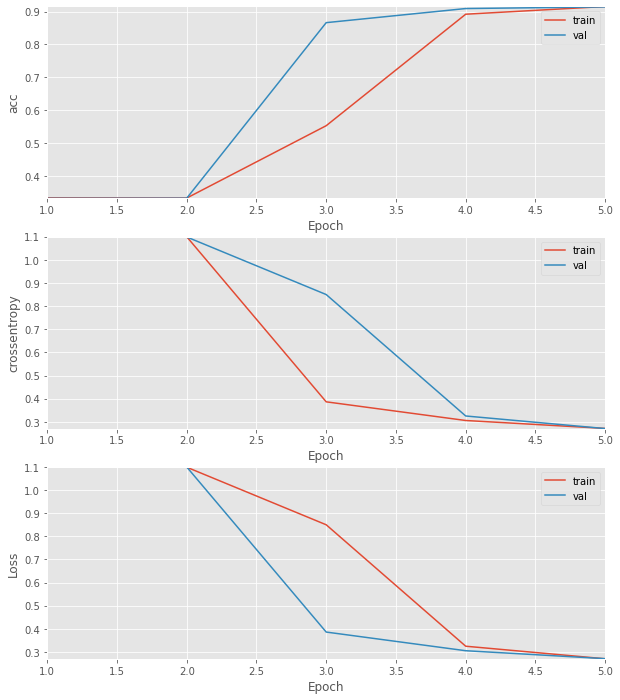

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10, 12))
    ax1, ax2, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['acc'], history.history['val_acc'], 'acc')
    plot_metrix(ax2, history.history['val_sparse_categorical_crossentropy'], history.history['sparse_categorical_crossentropy'], 'crossentropy')
    #plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    

    
    
    plt.show()


plot_history(history)

In [17]:
model.save_weights('glove.6B.300d-2.hdf5')

## 5. SKOS ontology creation from text

In [ ]:
import pandas as pd
import numpy as np
import codecs
f='motor.txt'
text2 = codecs.open(f, 'r', encoding='utf-8', errors='ignore')
text=text2.read()

In [11]:
print(text)

Hydraulic motor types
Vane motor
A vane motor consists of a housing with an eccentric bore, in which runs a rotor with vanes in it that slide in and out. The force differential created by the unbalanced force of the pressurized fluid on the vanes causes the rotor to spin in one direction. A critical element in vane motor design is how the vane tips are machined at the contact point between vane tip and motor housing. Several types of "lip" designs are used, and the main objective is to provide a tight seal between the inside of the motor housing and the vane, and at the same time to minimize wear and metal-to-metal contact.
Gear motor
A gear motor (external gear) consists of two gears, the driven gear (attached to the output shaft by way of a key, etc.) and the idler gear. High pressure oil is ported into one side of the gears, where it flows around the periphery of the gears, between the gear tips and the wall housings in which it resides, to the outlet port. The gears then mesh, not 

In [12]:
import string
import re
import pymorphy2

words = re.findall(r"[\w']+|[.,!?;]", text)
sen=text.split('.')

In [13]:
print(len(sen))
print(len(words))

43
944


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = sen

vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_df=20, min_df=2, max_features=200) 
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['chassis and', 'commercial vehicles', 'for commercial', 'hull serves', 'in the', 'of the', 'on the', 'rolling chassis', 'serves as', 'the afv', 'the chassis', 'without the']


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = sen
vectorizer = TfidfVectorizer(max_df=0.99, min_df=20, max_features=1000,
                                  )
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

ValueError: max_df corresponds to < documents than min_df

In [3]:
import gensim
import spacy
import os
import random
import numpy as np
from datetime import datetime
from tqdm import tqdm

C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-

In [16]:
def dot(A, B):
    return sum(a * b for a, b in zip(A, B))
# Косинусное расстояние
def get_similarity(a, b):
    similarity = dot(a, b) / ((dot(a, a) ** .5) * (dot(b, b) ** .5))
    return round(similarity, 7)

In [4]:
def get_concept_vector(concept, use_pos=False, use_lemma=True):
    if concept in concept_buffer.keys():
        return concept_buffer[concept]

    doc = nlp(concept)
    doc = [token for token in doc if token.pos_ not in POS_EXCEPTIONS]
    if len(doc) == 0:
        concept_buffer.update({concept: []})
        return []

    vectors = []
    for token in doc:
        try:
            if use_pos:
                vectors.append(model[f"{token.text}_{token.pos_}"])
            else:
                vectors.append(model[token.text])

        except KeyError:
            if use_lemma:
                try:
                    if use_pos:
                        vectors.append(model[f"{token.lemma_}_{token.pos_}"])
                    else:
                        vectors.append(model[token.lemma_])

                except KeyError:
                    concept_buffer.update({concept: []})
                    return []
            else:
                concept_buffer.update({concept: []})
                return []

    concept_vector = np.mean(vectors, axis=0)
    concept_buffer.update({concept: concept_vector})
    return concept_vector

In [5]:
SEP = '|'
BROADER_STRIPPED_FILE = True
UNIQUE_BROADER_CONCEPTS = True
POS_EXCEPTIONS = ['PUNCT',] #  'ADP'
SPACY_MODEL = 'en_core_web_lg'
MODELS_USING_POS_TAG = ['200l.bin', ]
NOISE_FILE_AMOUNT = 2
model_path='glove.6B.300d.bin'

In [6]:
nlp = spacy.load(SPACY_MODEL)
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)
concept_buffer = {}

In [8]:
related_result_file = os.path.join("all_motor.csv")

In [19]:
model_use_pos=False
r_counter=0
for i in range(len(words)):
    for ii in range(len(words)):
        if(len(words[i])>3):
            if(len(words[ii])>3):
                 if(words[ii]!=words[i]):
                    w1 = nlp(words[i])
                    wl1=w1[0].lemma_
                    w2 = nlp(words[ii])  
                    wl2=w2[0].lemma_
                    main_concept_vector = get_concept_vector(wl1, model_use_pos)
                    if any(main_concept_vector):
                            sub_concept_vector = get_concept_vector(wl2, model_use_pos)
                            if any(sub_concept_vector):
                                #main_concept_vector = model[wl1]
                                #sub_concept_vector = model[wl2]
                                similarity = get_similarity(main_concept_vector, sub_concept_vector) 
                                #print (wl1,wl2,similarity)
                                main_concept_vector = SEP.join(main_concept_vector.astype(str))
                                sub_concept_vector = SEP.join(sub_concept_vector.astype(str))
                                result = SEP.join(
                                (wl1,wl2,main_concept_vector, str(similarity), sub_concept_vector))
                                if result:
                                    with open(related_result_file, 'a', encoding='utf-8') as result_file:
                                        result_file.write(result+'\n')
                                    r_counter+=1

In [ ]:
#load data
data = pd.read_csv('all_motor.csv', sep="|", header=None,low_memory=True)
X = data.iloc[:,2:602].astype(float)

In [8]:
#load model for prediction
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(600,), name='digits')
x = layers.Dense(500, activation='softmax', name='dense_1')(inputs)
y = layers.Dense(350, activation='sigmoid', name='dense_2')(x)#sigmoid
z = layers.Dense(250, activation='softmax', name='dense_3')(y)
z1 = layers.Dense(150, activation='softmax', name='dense_4')(z)
outputs = layers.Dense(3, activation='softmax', name='predictions')(z1)
model = keras.Model(inputs=inputs, outputs=outputs)
model.load_weights('glove.6B.300d-2.hdf5')

C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dikov\AppData\Roaming\Python\Python36\site-

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
S = data.iloc[:,0:2].astype(str)

In [5]:
print(S[0][1])

motor


In [9]:
#predict
predictions = model.predict(X)

In [11]:
print(predictions[0:20])
print(predictions[6][0])

[[4.8267882e-02 2.7006367e-01 6.8166846e-01]
 [2.7778295e-01 2.6701847e-01 4.5519853e-01]
 [2.1164073e-01 3.2086399e-01 4.6749526e-01]
 [2.1164073e-01 3.2086399e-01 4.6749526e-01]
 [9.9812549e-01 7.3818432e-04 1.1363311e-03]
 [9.2460090e-01 2.4735402e-02 5.0663732e-02]
 [3.4082811e-02 6.9966978e-01 2.6624748e-01]
 [9.9895561e-01 4.2123467e-04 6.2319555e-04]
 [3.0203782e-02 7.5137466e-01 2.1842156e-01]
 [2.5858122e-04 4.8050783e-03 9.9493635e-01]
 [2.9276258e-01 2.6194248e-01 4.4529495e-01]
 [4.3216143e-02 4.8165116e-01 4.7513264e-01]
 [6.7683044e-03 9.1311753e-01 8.0114119e-02]
 [6.2048759e-02 4.3951958e-01 4.9843174e-01]
 [9.9833292e-01 6.5983663e-04 1.0072929e-03]
 [3.8322661e-02 3.2022119e-01 6.4145613e-01]
 [9.9833459e-01 6.5920060e-04 1.0062519e-03]
 [9.2022145e-01 2.6118033e-02 5.3660508e-02]
 [1.0278156e-01 3.9211813e-01 5.0510031e-01]
 [2.4153626e-01 2.5710690e-01 5.0135684e-01]]
0.03408281


In [16]:
# float to skos relation
rel=-1
for i in range(0,297):
    if (predictions[i][0]>0.6): 
      #  if (predictions[i][1]<0.01):
      #      if (predictions[i][2]<0.01): 
                rel =0
                #print(S[0][i],' `0` ',S[1][i])
    if (predictions[i][1]>0.6): 
      #  if (predictions[i][2]<0.01): 
      #      if (predictions[i][0]<0.01): 
                rel =1
                print(S[0][i],' -broader-  ',S[1][i])
                #print(predictions[i])
    if (predictions[i][2]>0.6):
      #  if (predictions[i][1]<0.01): 
       #     if (predictions[i][0]<0.01): 
                rel =2
                #print(S[0][i],' `2` ',S[1][i])
        

rotor  -broader-   run
force  -broader-   differential
pressurized  -broader-   fluid
drive  -broader-   gear
gear  -broader-   gear
attach  -broader-   gear
idler  -broader-   gear
outlet  -broader-   port
inlet  -broader-   side
small  -broader-   amount
drain  -broader-   port
vent  -broader-   line
hydraulic  -broader-   motor
distributor  -broader-   valve
plunger  -broader-   motor
rotate  -broader-   motor
drive  -broader-   system
plunger  -broader-   motor
hydraulic  -broader-   pump
plunger  -broader-   motor
litre  -broader-   motor
piston  -broader-   motor
hydraulic  -broader-   system
piston  -broader-   motor
hydraulic  -broader-   motor
hydraulic  -broader-   motor
piston  -broader-   motor
hydraulic  -broader-   motor
piston  -broader-   motor
piston  -broader-   motor
cylinder  -broader-   shoe
con  -broader-   pro
rotary  -broader-   power
piston  -broader-   roller
